In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy import signal
from astropy.io import fits

In [2]:
noise = fits.getdata('C:/Users/vovaz/Desktop/my stuff/Code/Projects/linux_run/cm21fast/noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K.fits')

In [3]:
np.shape(noise)

(342, 128, 128)

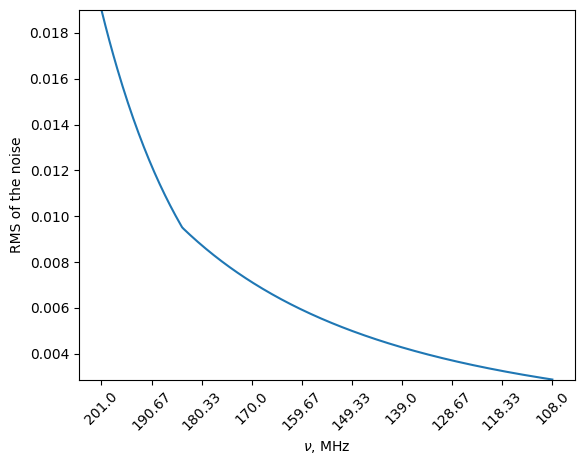

In [15]:
x_rng = np.linspace(201, 108, 10).round(2)
tick_positions = np.linspace(0, 341, 10)

rms = []

for i in range(342):
    rms.append(np.sqrt(np.mean(noise[i,:,:]**2)))



fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_xticks(tick_positions)
ax.set_xticklabels(x_rng, rotation=45)
#ax.plot([210, 210], [np.min(rms), rms[210]], '--k')
ax.set_ylim(np.min(rms), np.max(rms))
ax.set_xlabel(r'$\nu$, MHz')
ax.set_ylabel(r'RMS of the noise')
ax.plot(rms)

In [12]:
gaussian_noise = np.random.normal(0, 1.9, (64, 64))
noise_cube = np.zeros((64,64,86))

for i in range(86):
    noise_cube[:,:,i] = np.random.normal(0,1.9, size=(64, 64))

fov=3.0 # field of view in degrees
Dim = 64 # pixels per side
t_int_h = 1000 # number of hours to normalise noise to
n_f = 86 # number of frequencies
del_nu = (50/86)*10**6 # frequency interval / Hz
f1 = 108.0 # first frequency map / MHz

#################### Advanced Use #################### 
#SKA

n_tiles = 1 # per station
n_dipoles = 256 # per tile
tel = 'SKA_central_area'
Di = 8 # from baseline design.
const_PSF = 1
PSF_from_headers = 0
if (tel=='SKA_core_area'):
    n_stations = 224 #224
    D =  1000  #3400
elif (tel=='SKA_central_area'):
    n_stations = 296
    D =  3400

c = 2.998e8
eta_a = 1.0 #antenna efficiency
pi = 3.14159
k_b = 1.38e-23
eta_s=0.9 #system efficiency


t_int = t_int_h*3600. # integration time / s


FWHM_arcmin = 4.0
sz=[Dim,Dim]

W = 1.3 #weighting factor (1.3-2) #WE SET THIS AS 1 FOR SUSSEX but also didnt have factor of 2. with equation as they are now, set to 2 to get 67 mK at 150 MHz for 48 stattions. 1.3 89 mK for 24 stations . set to 1.3 to match website.

slice_norm = np.zeros(shape=(sz[0],sz[1]))

noise_norm = np.zeros((64,64,86))


for kk in range(0,n_f):

    freq = f1 + (del_nu*1e-6)*kk
    cube = gaussian_noise
    cube = np.squeeze(cube)
    lamb = c/(freq*1e6)
    # Calculate T_sys
    T_sys = 40.0 + 1.1*60.0*(freq*1e6/c)**(-2.55) # from Table 3 https://astronomers.skatelescope.org/wp-content/uploads/2016/12/SKA-TEL-SKO-DD-001-1_BaselineDesign1.pdf
    # Calculate effective area at each frequency
    eta_rad = (0.056 * freq +82.2)/100.0 # worked out since 85 at 50 MHz and 99 at 300. asssumed linear.
    A_di=lamb**2/(4*pi)*eta_rad*Di #from Table 3 https://astronomers.skatelescope.org/wp-content/uploads/2016/12/SKA-TEL-SKO-DD-001-1_BaselineDesign1.pdf foot note
    if (A_di > 3.2):
        A_di=3.2 # Lower frequencies limited by antenna area
    A=A_di*n_dipoles*n_tiles # Area per station.
 # Calculate SEFD at each frequency.
        #print freq, T_sys-140,A/T_sys
    K=(A)/(2.0*k_b)
    SEFD=T_sys/K # in J m^-2=W m^-2 Hz^-1
    SEFD=SEFD*1.0e26 # in Jy
 # Calculate noise sensitivities in Jy # NOW INCLUDESS FACTOR OF 2.
    noise_Jy=(W/eta_s)*(SEFD/np.sqrt(2*n_stations*(n_stations-1)*del_nu*t_int))
  #  file.write('%e \n'%(noise_Jy))
  #  file2.write('%e \n'%(freq*1e6))

    rms =0.
    for ii in range(0,sz[0]):
        for jj in range(0,sz[1]):
            rms = rms + cube[ii,jj]**2
    rms = np.sqrt(rms/(sz[0]*sz[1]))  # this is in Jy/beam.

    if (const_PSF == 1):
        FWHM = (FWHM_arcmin/60.0)*(pi/180.0)
    else:
        FWHM = 1.22 * lamb / D  # radians
               # print kk,lamb,FWHM

    beamarea = pi * FWHM**2 / (4.0*np.log(2)) # beam solid angle of Gaussian beam

    slice_norm[:,:] = cube[:,:] * (noise_Jy/rms)

    rms_norm =0.
    for ii in range(0,sz[0]):
        for jj in range(0,sz[1]):
            rms_norm = rms_norm + slice_norm[ii,jj]**2

    rms_norm = np.sqrt(rms_norm/(sz[1]*sz[0]))
   # print(noise_Jy, rms_norm)

    slice_norm = slice_norm *1e-26*(c/(freq*1.0e6))**2*(1.0/(2.0*k_b*beamarea)) # converting from Jy/beam to K.
   # print(noise_Jy)
   # print(noise_Jy*1e-26*(c/(freq*1.0e6))**2*(1.0/(2.0*k_b*beamarea)))
   # print(noise_Jy/beamarea*1e-26*(c/(freq*1.0e6))**2*(1.0/(2.0*k_b*beamarea)))
    rms_norm =0.
    for ii in range(0,sz[0]):
        for jj in range(0,sz[1]):
            rms_norm = rms_norm + slice_norm[ii,jj]**2
    rms_norm = np.sqrt(rms_norm/(sz[1]*sz[0]))

    noise_norm[:,:,kk] = noise_cube[:,:,kk]*slice_norm


rms_test = []

for i in range(86):
    rms_test.append(np.sqrt(np.mean(noise_norm[:,:,i]**2)))

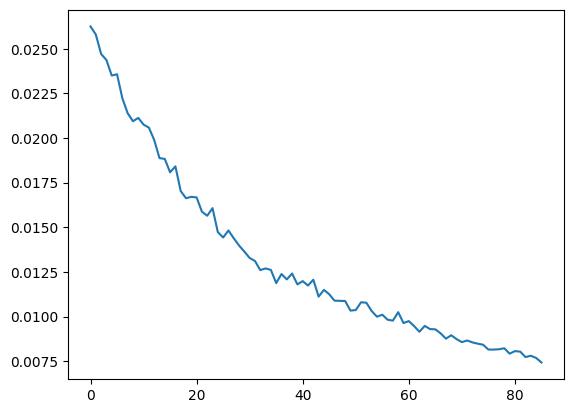

In [14]:
plt.plot(rms_test)

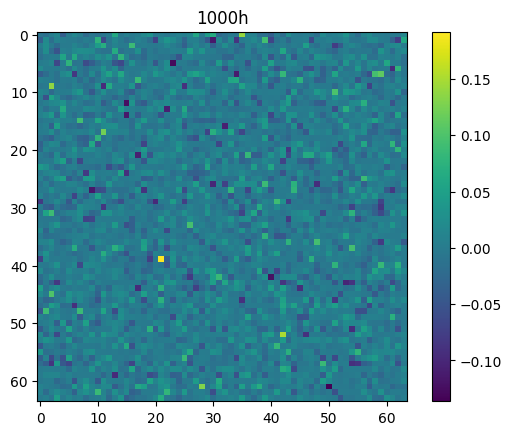

In [99]:
plt.subplot(111)
plt.title("1000h")
plt.imshow(noise_norm[:,:,0])
plt.colorbar()

0.06186163252094504


Text(0.5, 1.0, '5000h ; STD = 0.015')

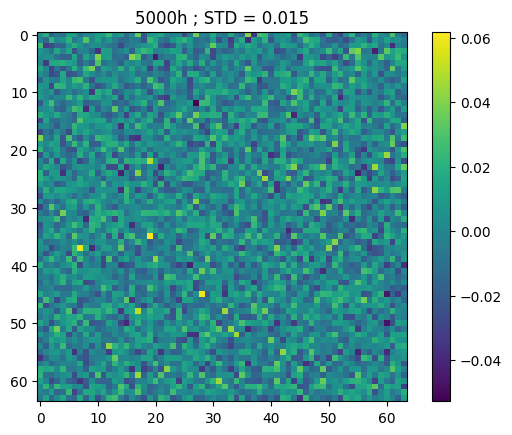

In [109]:
#a = np.random.normal(0, 0.045, (64, 64)) # 1000h normalisation
a = np.random.normal(0, 0.015, (64, 64)) # 5000h normalisation
plt.imshow(a)
print(np.max(a))
plt.colorbar()
plt.title("5000h ; STD = 0.015")